In [1]:
import os
import numpy as np
import yaml
import pprint
import matplotlib.pyplot as plt
import utils.signals.gps_l1ca as gps_l1ca
import utils.sample_processing.sample_streaming as sample_streaming
import utils.sample_processing.bpsk_acquisition as bpsk_acquisition
import utils

In [2]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")

collect_metadata_filepath = os.path.join(raw_collects_dir, "metadata.yml")
with open(collect_metadata_filepath, "r") as f:
    collect_metadata = yaml.safe_load(f)
    
# pprint.pprint(collect_metadata)
collect_filepaths = {
    collect_id: os.path.join(raw_collects_dir, collect_info["filename"])
    for collect_id, collect_info in collect_metadata["collections"].items()
}

samp_rate = collect_metadata["samp_rate"]
inter_freq_l1_hz = collect_metadata["bands"]["L1"]["inter_freq"]
sample_params_dict = collect_metadata["sample_params"]
sample_params = sample_streaming.SampleParameters.from_dict(sample_params_dict)
print(f"Sample rate: {samp_rate/1e6} MHz")
# pprint.pprint(sample_params_dict)
pprint.pprint(sample_params)

collect_id_list = sorted(collect_filepaths.keys())
print("Available collects:")
for collect_id in collect_id_list:
    print(f"  {collect_id}: {os.path.basename(collect_filepaths[collect_id])}")

collect_id = collect_id_list[0]
collect_filepath = collect_filepaths[collect_id]
print(f"Using collect ID: {collect_id}")
# print(f"  Filepath: {collect_filepath}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Sample rate: 25.0 MHz
SampleParameters(bit_depth=4,
                 is_complex=True,
                 is_integer=True,
                 is_signed=True,
                 is_i_lsb=True)
Available collects:
  20220513_173218_USRP2: CO_A2_20220513_173218_000211_G1_B1_USRP2.sc4
Using collect ID: 20220513_173218_USRP2


In [3]:
buffer_duration_ms = 40
buffer_size_samples = int(samp_rate * buffer_duration_ms / 1e3)
buffer_size_bytes = sample_streaming.compute_sample_array_size_bytes(
    buffer_size_samples, sample_params.bit_depth, sample_params.is_complex
)
byte_buffer = bytearray(buffer_size_bytes)
sample_buffer = np.zeros(buffer_size_samples, dtype=np.complex64)

with open(collect_filepath, "rb") as f:
    f.readinto(byte_buffer)

sample_streaming.convert_to_complex64_samples(
    byte_buffer,
    sample_buffer,
    sample_params
)
baseband_sample_buffer = np.zeros(buffer_size_samples, dtype=np.complex64)
sample_streaming.mixdown_samples(
    sample_buffer,
    baseband_sample_buffer,
    samp_rate,
    0.0,
    inter_freq_l1_hz
)

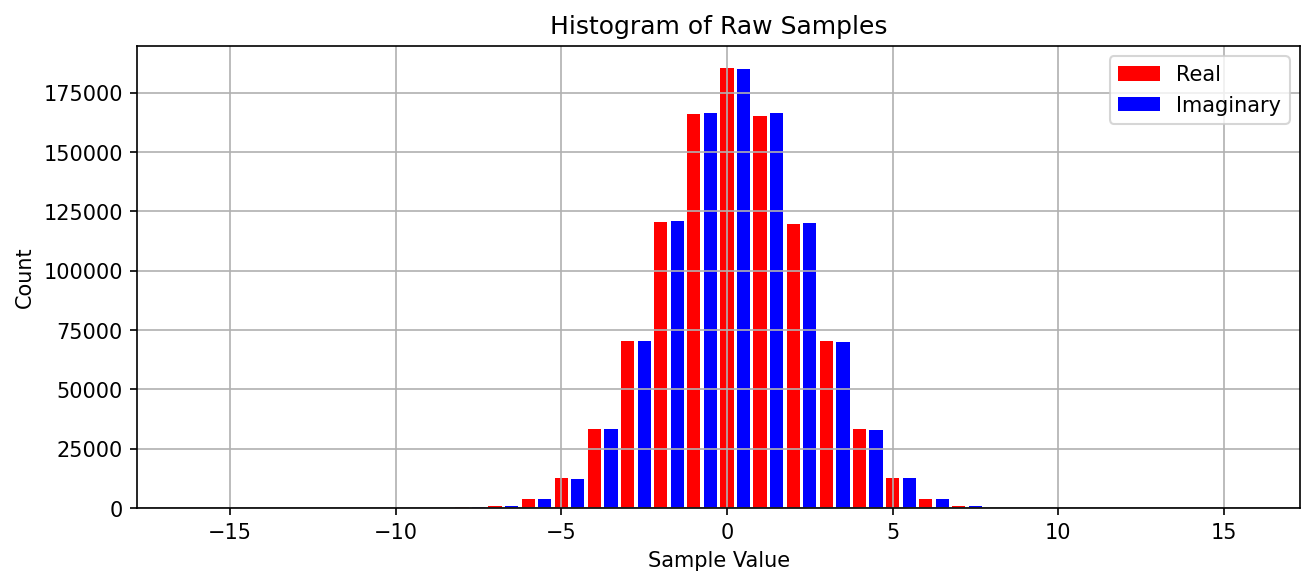

In [4]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
hist_bins = np.arange(-16, 17)
ax.hist(sample_buffer.real, bins=hist_bins, rwidth=0.4, color="r", align="left", label="Real")
ax.hist(sample_buffer.imag, bins=hist_bins, rwidth=0.4, color="b", align="mid", label="Imaginary")
ax.set_title("Histogram of Raw Samples")
ax.set_xlabel("Sample Value")
ax.set_ylabel("Count")
ax.legend()
ax.grid()
plt.show()

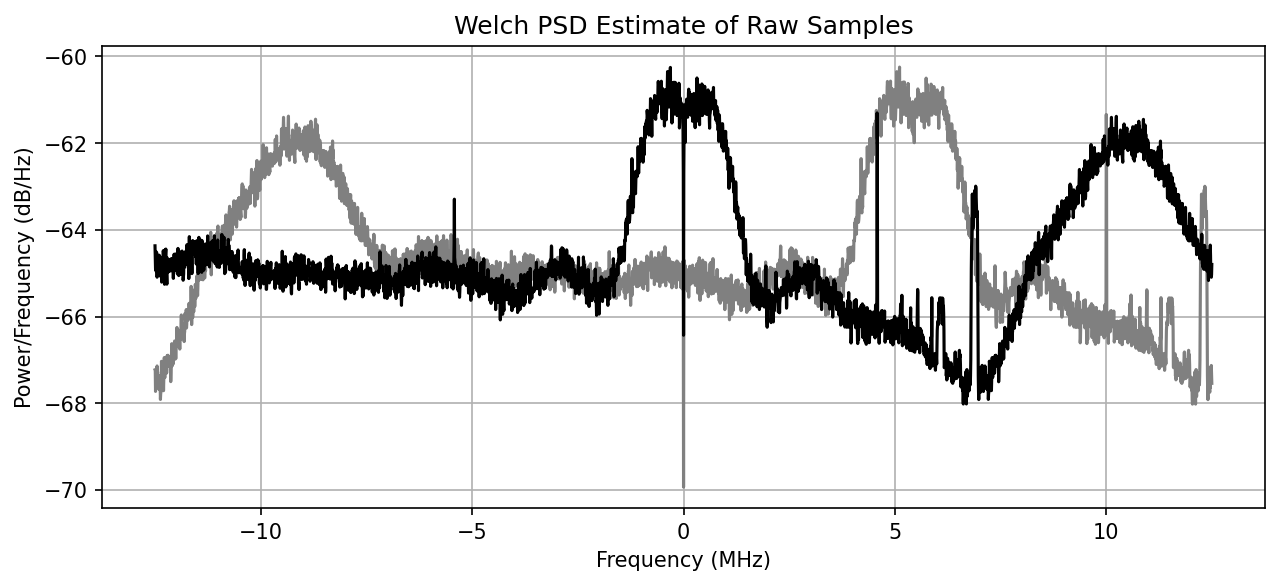

In [5]:
# Plot Welch PSD estimate of the samples
import scipy.signal
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
freqs, psd_orig = scipy.signal.welch(
    sample_buffer,
    fs=samp_rate,
    nperseg=4096,
    noverlap=2048,
    window="hann",
    return_onesided=False,
    scaling="density",
)
_, psd = scipy.signal.welch(
    baseband_sample_buffer,
    fs=samp_rate,
    nperseg=4096,
    noverlap=2048,
    window="hann",
    return_onesided=False,
    scaling="density",
)
freqs = np.fft.fftshift(freqs)
psd_orig = np.fft.fftshift(psd_orig)
psd = np.fft.fftshift(psd)
# ax.plot(freqs/1e6, 10*np.log10(psd_orig), color="black")
ax.plot(freqs/1e6, 10*np.log10(psd_orig), color="gray")
ax.plot(freqs/1e6, 10*np.log10(psd), color="black")
ax.set_title("Welch PSD Estimate of Raw Samples")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power/Frequency (dB/Hz)")
ax.grid()
plt.show()

In [6]:
GPS_L1CA_acq_code_params = {
    f"G{prn:02}": bpsk_acquisition.AcqSignalCodeParameters(
        rate_chips_per_sec=gps_l1ca.CODE_RATE,
        length_chips=gps_l1ca.CODE_LENGTH,
        sequence=gps_l1ca.get_GPS_L1CA_code_sequence(prn),
    ) for prn in range(1, 33)
}

acq_config = bpsk_acquisition.AcquisitionConfiguration(
    replica_duration_ms=4,
    num_blocks=8,
    sample_rate=samp_rate,
    min_search_doppler_hz=-5000,
    max_search_doppler_hz=5000,
)

# Compute bin probability of false alarm
# If we treat each delay/Doppler bin as single detection test
# individual probability of false alarm per bin p_fa_bin
# yields overall probability of false alarm p_fa_total
num_doppler_bins = acq_config.num_doppler_bins
num_code_phase_bins = acq_config.replica_length_samples
num_detection_tests = num_doppler_bins * num_code_phase_bins
print(f"Acq. num Doppler bins: {num_doppler_bins}")
print(f"Acq. num code phase bins: {num_code_phase_bins}")
print(f"Number of detection tests per signal: {num_detection_tests}")
p_fa_total = 1e-6
p_fa_bin = 1 - (1 - p_fa_total) ** (1 / num_detection_tests)
print(f"Desired overall P_fa: {p_fa_total:.2e}, per-bin P_fa: {p_fa_bin:.2e}")
print("")

acq_results = bpsk_acquisition.run_acquisition(
    baseband_sample_buffer,
    acq_config,
    GPS_L1CA_acq_code_params,
    prob_false_alaram=p_fa_bin,
    print_progress=True
)

Acq. num Doppler bins: 40
Acq. num code phase bins: 100000
Number of detection tests per signal: 4000000
Desired overall P_fa: 1.00e-06, per-bin P_fa: 2.50e-13

Acquiring signal G01...264.950*
Acquiring signal G02...200.097*
Acquiring signal G03...152.319*
Acquiring signal G04...84.098
Acquiring signal G05...76.749
Acquiring signal G06...1760.959*
Acquiring signal G07...84.268
Acquiring signal G08...77.160
Acquiring signal G09...81.013
Acquiring signal G10...90.856
Acquiring signal G11...174.710*
Acquiring signal G12...96.376*
Acquiring signal G13...226.982*
Acquiring signal G14...1491.113*
Acquiring signal G15...78.572
Acquiring signal G16...78.364
Acquiring signal G17...1156.400*
Acquiring signal G18...77.399
Acquiring signal G19...2077.120*
Acquiring signal G20...79.160
Acquiring signal G21...80.214
Acquiring signal G22...85.406
Acquiring signal G23...77.174
Acquiring signal G24...251.898*
Acquiring signal G25...78.375
Acquiring signal G26...75.323
Acquiring signal G27...74.246
Acqu

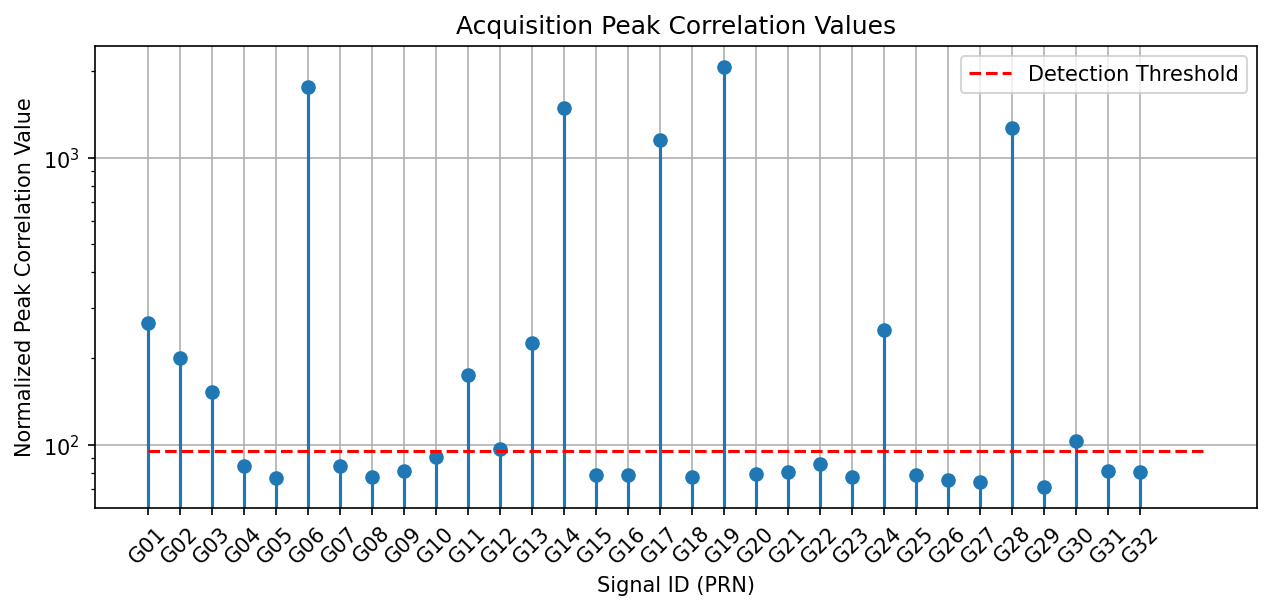

In [14]:
# Plot peak amplitudes
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
all_sig_ids = sorted(acq_results.keys())
all_peak_vals = [
    acq_results[sig_id].normalized_peak_value
    for sig_id in all_sig_ids
]
ax.stem(range(len(all_peak_vals)), all_peak_vals, basefmt=" ")
detection_threshold = acq_results["G01"].detection_threshold
ax.plot([0, 33], [detection_threshold] * 2, color="red", linestyle="--", label="Detection Threshold")
ax.legend()
ax.set_yscale("log")
ax.set_xticks(range(len(all_sig_ids)))
ax.set_xticklabels(all_sig_ids, rotation=45)
ax.set_title("Acquisition Peak Correlation Values")
ax.set_xlabel("Signal ID (PRN)")
ax.set_ylabel("Normalized Peak Correlation Value")
ax.grid()
plt.show()

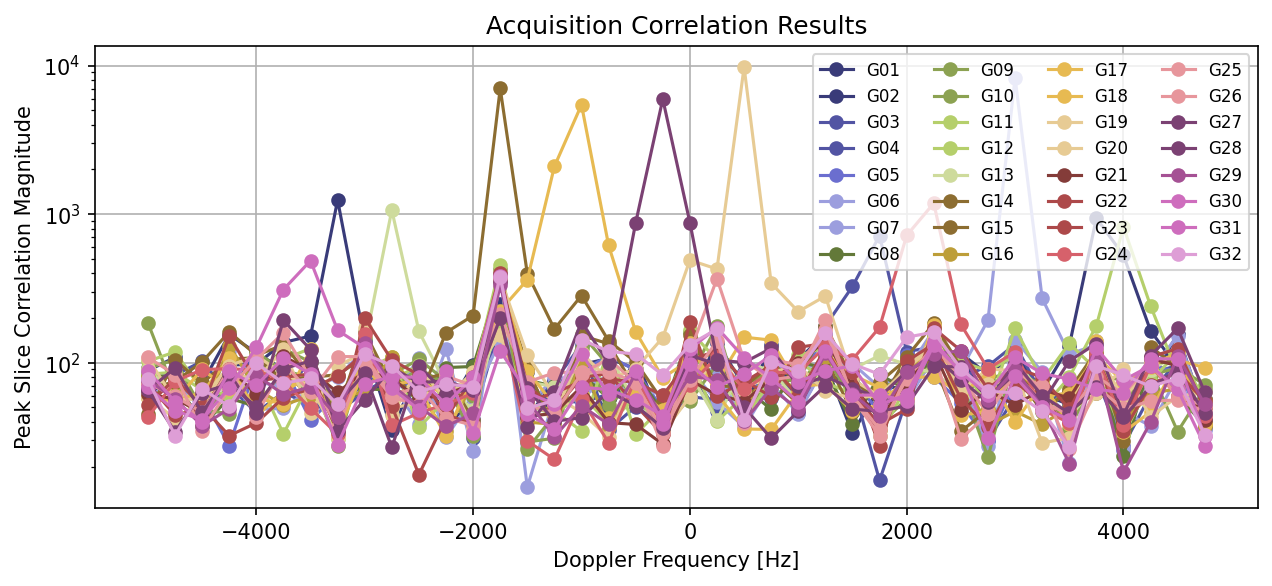

In [15]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
cmap = plt.get_cmap("tab20b")
for i, (signal_id, acq_result) in enumerate(acq_results.items()):
    color = cmap(i / 32.0)
    ax.plot(
        acq_result.correlation_result.doppler_bins_hz,
        acq_result.correlation_result.correlation_matrix[:, acq_result.peak_code_phase_bin],
        color=color,
        marker="o",
        # label=f"{signal_id} (SNR={acq_result.acq_snr_dB:.1f} dB)",
        label=f"{signal_id}",
    )
ax.set_yscale("log")
ax.set_title("Acquisition Correlation Results")
ax.set_xlabel("Doppler Frequency [Hz]")
ax.set_ylabel("Peak Slice Correlation Magnitude")
ax.legend(ncol=4, fontsize=8)
ax.grid()
plt.show()

In [16]:
# print acquired signal dopplers
acquired_dopplers = []
for sig_id, acq_result in acq_results.items():
    if acq_result.normalized_peak_value < 200:
        continue
    acquired_dopplers.append(acq_result.acq_doppler_hz)

Peak correlation at Doppler: -3500.0 Hz, Code Phase: 25817 samples


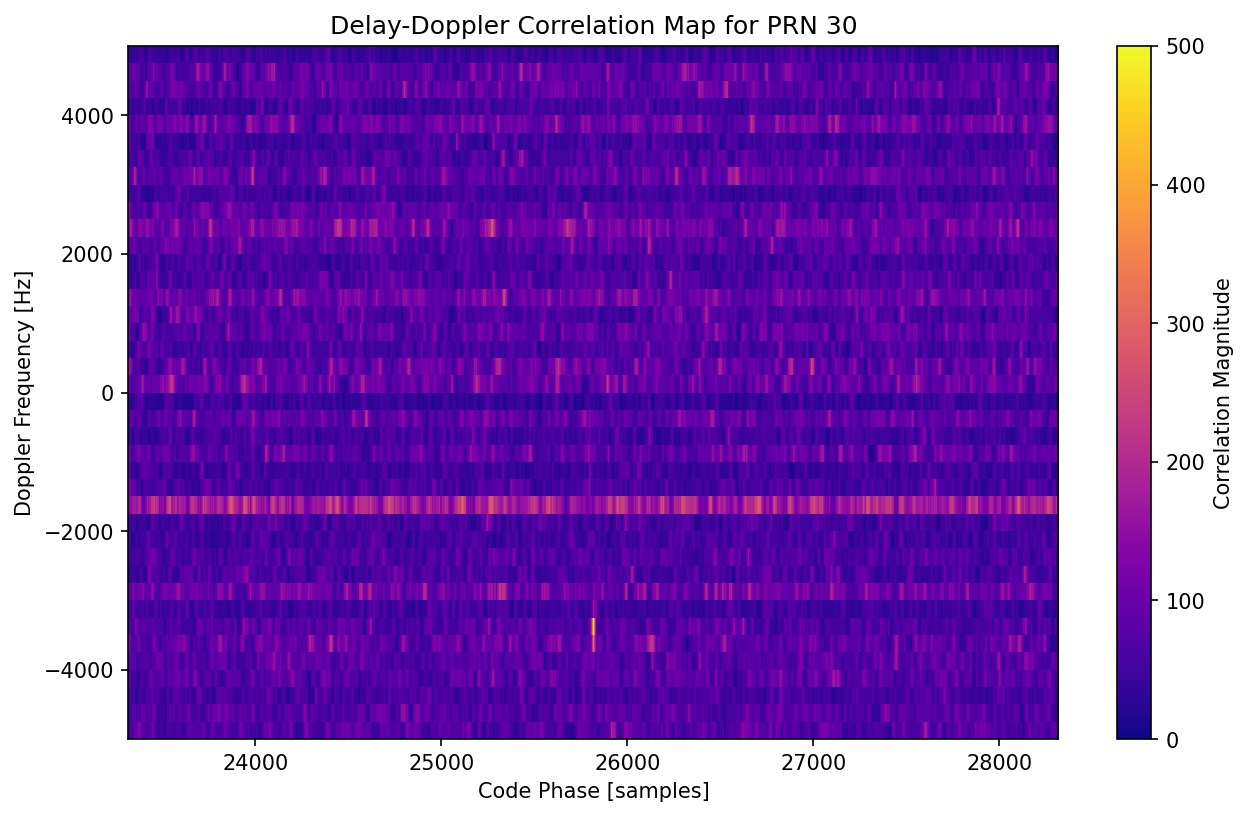

In [18]:
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(111)
sig_id = "G30"
acq_result = acq_results[sig_id]
acq_config = acq_result.config
correlation = acq_result.correlation_result.correlation_matrix
num_doppler_bins, num_code_phases = correlation.shape
extent = [0, num_code_phases, acq_config.min_search_doppler_hz, acq_config.max_search_doppler_hz]

peak_doppler_bin = acq_result.peak_doppler_bin
peak_doppler_hz = acq_result.correlation_result.doppler_bins_hz[peak_doppler_bin]
peak_code_phase_bin = acq_result.peak_code_phase_bin
print(f"Peak correlation at Doppler: {peak_doppler_hz} Hz, Code Phase: {peak_code_phase_bin} samples")

im = ax.imshow(
    correlation,
    extent=extent,
    aspect="auto",
    interpolation="nearest",
    cmap="plasma",
    origin="lower",
    # vmin=noise_power,
    vmin=0,
    vmax=500
)
# ax.hlines(acquired_dopplers, 0, num_code_phases, colors="white", linestyles="--", label="Acquired Dopplers")
# code_phase_window = 30000  # samples
code_phase_window = 2500  # samples
ax.set_xlim(peak_code_phase_bin - code_phase_window, peak_code_phase_bin + code_phase_window)
ax.set_xlabel("Code Phase [samples]")
ax.set_ylabel("Doppler Frequency [Hz]")
ax.set_title(f"Delay-Doppler Correlation Map for PRN {int(sig_id[1:])}")
plt.colorbar(im, label="Correlation Magnitude")
plt.show()

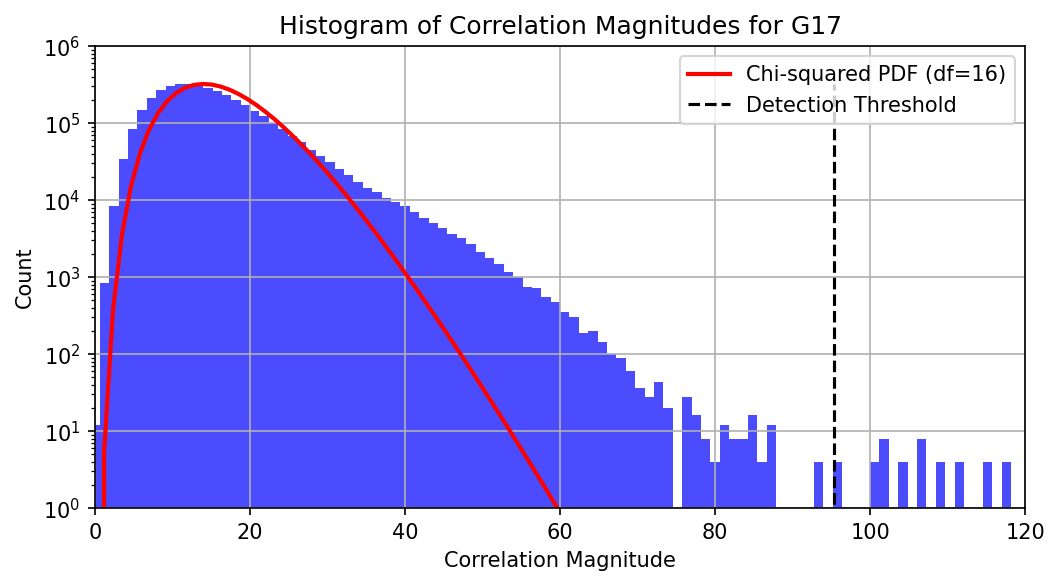

In [19]:
sig_id = "G17"
acq_result = acq_results[sig_id]
corr_matrix = acq_result.correlation_result.correlation_matrix

y_noise_mean = np.mean(corr_matrix)
sigma_n = np.sqrt(y_noise_mean / (2 * acq_config.num_blocks))
# sigma_n = np.std(sample_buffer)

# y_noise_var = np.var(corr_matrix)
# sigma_n = np.sqrt(np.sqrt(y_noise_var / (4 * acq_config.num_blocks)))


normalized_corr_matrix = corr_matrix / sigma_n**2
# hist_max_val = np.max(normalized_corr_matrix)
hist_max_val = 120

hist_bins = np.linspace(0, hist_max_val, 100)
hist = np.histogram(normalized_corr_matrix.flatten(), bins=hist_bins)[0]

# plot corr matrix histogram
fig = plt.figure(figsize=(8, 4), dpi=150)
# fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.bar(
    hist_bins[:-1],
    hist,
    width=hist_bins[1]-hist_bins[0],
    color="blue",
    alpha=0.7,
)
# add chi-squared distribution overlay
x_vals = np.linspace(0, np.max(normalized_corr_matrix), 1000)
chi2_pdf = scipy.stats.chi2.pdf(x_vals, df=2 * acq_config.num_blocks)
ax.plot(
    x_vals,
    chi2_pdf * np.max(hist) / np.max(chi2_pdf),
    color="red",
    linewidth=2,
    label=f"Chi-squared PDF (df={2 * acq_config.num_blocks})",
)
ax.vlines([acq_result.detection_threshold], ymin=0, ymax=np.max(hist), color="black", linestyle="--", label="Detection Threshold")
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1, 1e6)
ax.set_title(f"Histogram of Correlation Magnitudes for {sig_id}")
ax.set_xlabel("Correlation Magnitude")
ax.set_ylabel("Count")
ax.grid()
ax.set_xlim(0, 120)
plt.show()

In [20]:
# Save acquisition results to file
import pickle
acq_results_directory = os.path.join(data_dir, "acquisition-results")
os.makedirs(acq_results_directory, exist_ok=True)
acq_results_version_id = "v1"
acq_results_filepath = os.path.join(
    acq_results_directory, f"{collect_id}.{acq_results_version_id}.pkl")
with open(acq_results_filepath, "wb") as f:
    pickle.dump(acq_results, f)

In [13]:
# sidelobe stats causing heavy tails in histogram